# Using Cardiac Factors To Predict Whether Individuals Will Experience Heart Failure
#### Harsh A, Kyle M, Daniel L, Catarina A 

### Introduction
Cardiovascular diseases and heart failure account for the greatest amount of deaths per year globally, accounting for approximately a third of the global annual deaths. A large scale issue such as this is analyzed by doctors and engineers consistently to help civilians prevent their chances at contracting one of these diseases and ultimately helping to prevent their deaths by maximizing their health as much as possible. 

The main causes leading to heart failure are often associated with increased blood pressure (hypertension) and closing of the arteries (build-up of cholesterol and fats), both of which are indicated by an individual's maximum heart rate and are often associated with aging.

The goal of this project will be to use these factors from a heart failure data set, which includes the data and details from various heart disease patients, to successfully create a somewhat accurate model in order to diagnose whether an individual has heart disease and will experience heart failure.

**Question:** Can we predict whether a patient is going to experience heart failure (caused by heart disease) based on their age, resting blood pressure, cholesterol, and maximum heart rate?

### Preliminary Exploratory Data Analysis

In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

In [3]:
set.seed(50)
#loading raw dataset with new clean column names
heart_raw <- read_csv("https://raw.githubusercontent.com/hamin2006/Group_Project_7/main/data/heart1.csv",  
                       skip = 1, 
                       col_names = c("age","sex","chest_pain","resting_bp","cholesterol","fasting_bs","rest_ecg",
                                    "max_heart_rate","excercise_angina","old_peak","st_slope","heart_failure")) 

#cleaning data and selecting predictor variables
heart_data <- heart_raw |>
    mutate(heart_failure = case_when(heart_failure == 0 ~ "Healthy" , heart_failure == 1 ~ "Unhealthy"), 
           heart_failure = as_factor(heart_failure)) |> 
    select(age, resting_bp, cholesterol, max_heart_rate, heart_failure) 

#splitting clean data into training and testing sets
heart_split <- initial_split(heart_data, prop = 0.75, strata = heart_failure)

heart_training <- training(heart_split)
heart_testing <- testing(heart_split)

heart_training

Rows: 746 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): sex, chest_pain, rest_ecg, excercise_angina, st_slope
dbl (7): age, resting_bp, cholesterol, fasting_bs, max_heart_rate, old_peak,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,resting_bp,cholesterol,max_heart_rate,heart_failure
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
40,140,289,172,Healthy
37,130,283,98,Healthy
54,150,195,122,Healthy
⋮,⋮,⋮,⋮,⋮
68,144,193,141,Unhealthy
57,130,131,115,Unhealthy
57,130,236,174,Unhealthy


In [8]:
#summarization of training data
heart_training_summary <- heart_training |>
    group_by(heart_failure) |>
    summarize (patients = n(),
              mean_age = mean(age),
              mean_resting_bp = mean(resting_bp),
              mean_cholesterol = mean(cholesterol),
              mean_max_heart_rate = mean(max_heart_rate),
              missing_data = sum(is.na(heart_failure)) + sum(is.na(age)) + sum(is.na(resting_bp)) + sum(is.na(cholesterol)) + sum(is.na(max_heart_rate)))

heart_training_summary

heart_failure,patients,mean_age,mean_resting_bp,mean_cholesterol,mean_max_heart_rate,missing_data
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
Healthy,292,50.42808,129.4589,238.6199,150.2158,0
Unhealthy,267,56.57678,137.0861,248.3858,130.9288,0


Warning message:
“Removed 4 rows containing missing values (`geom_point()`).”


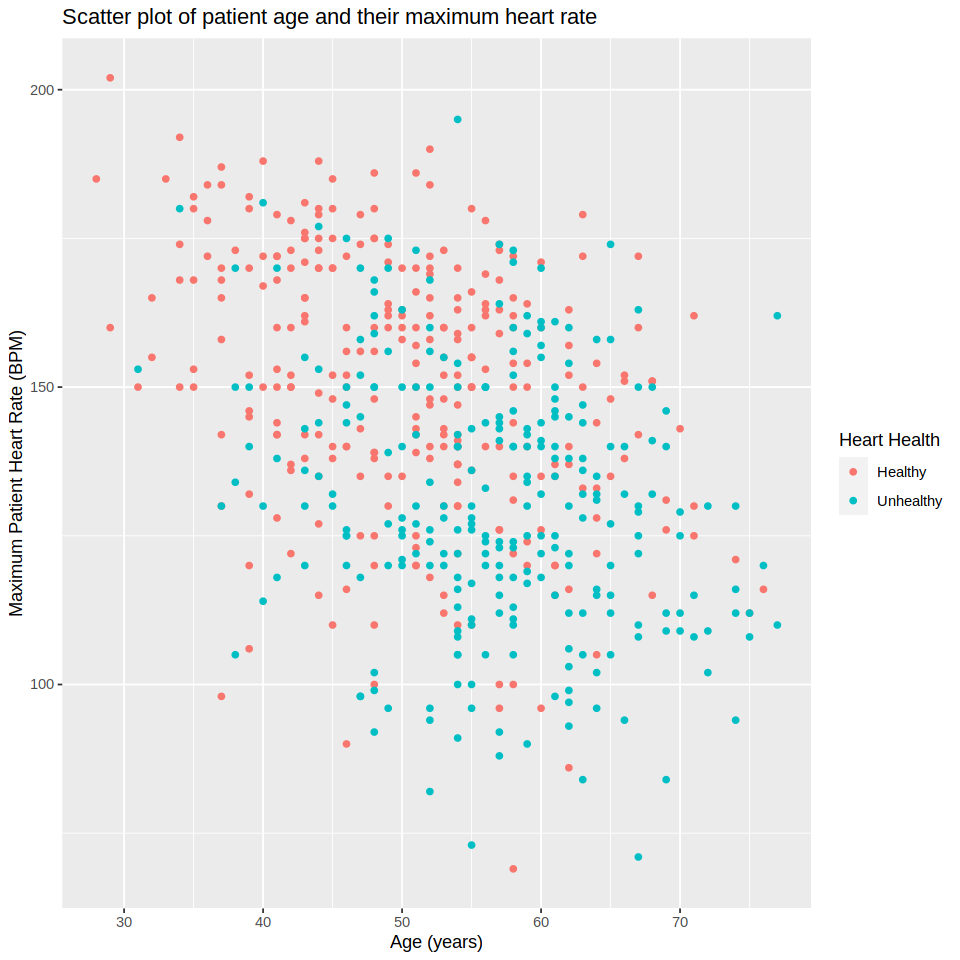

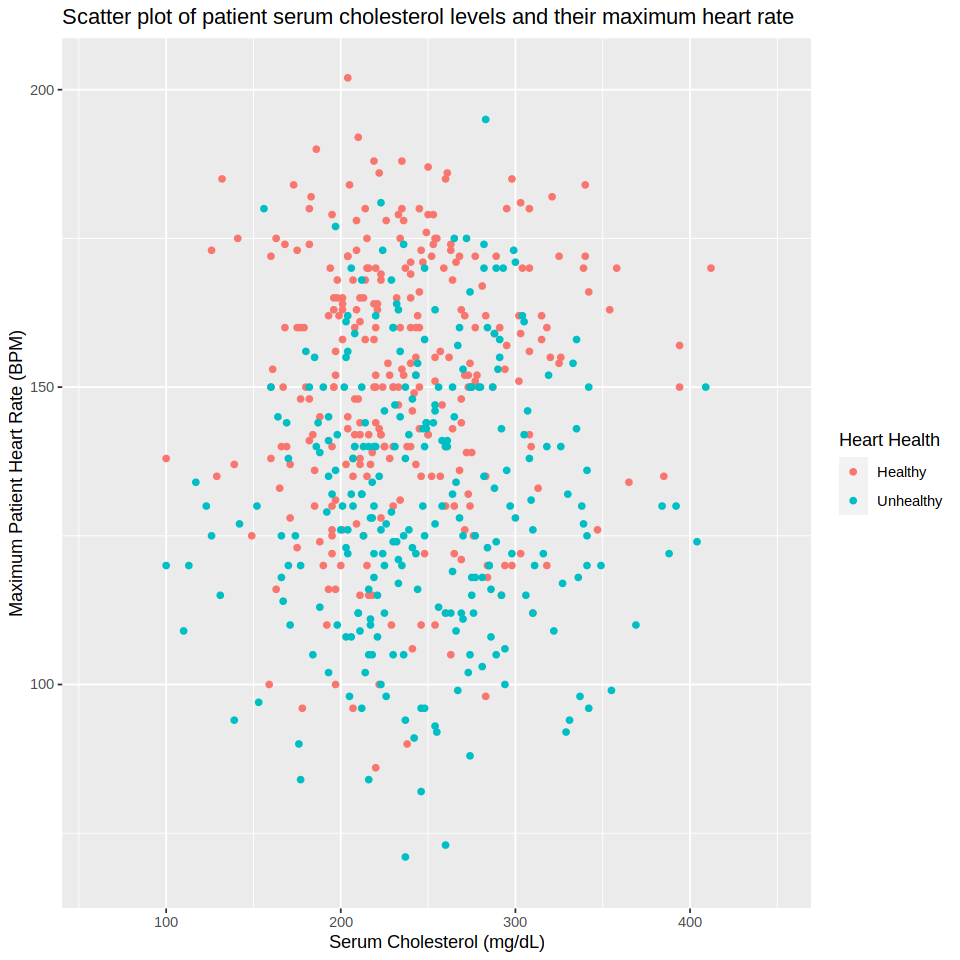

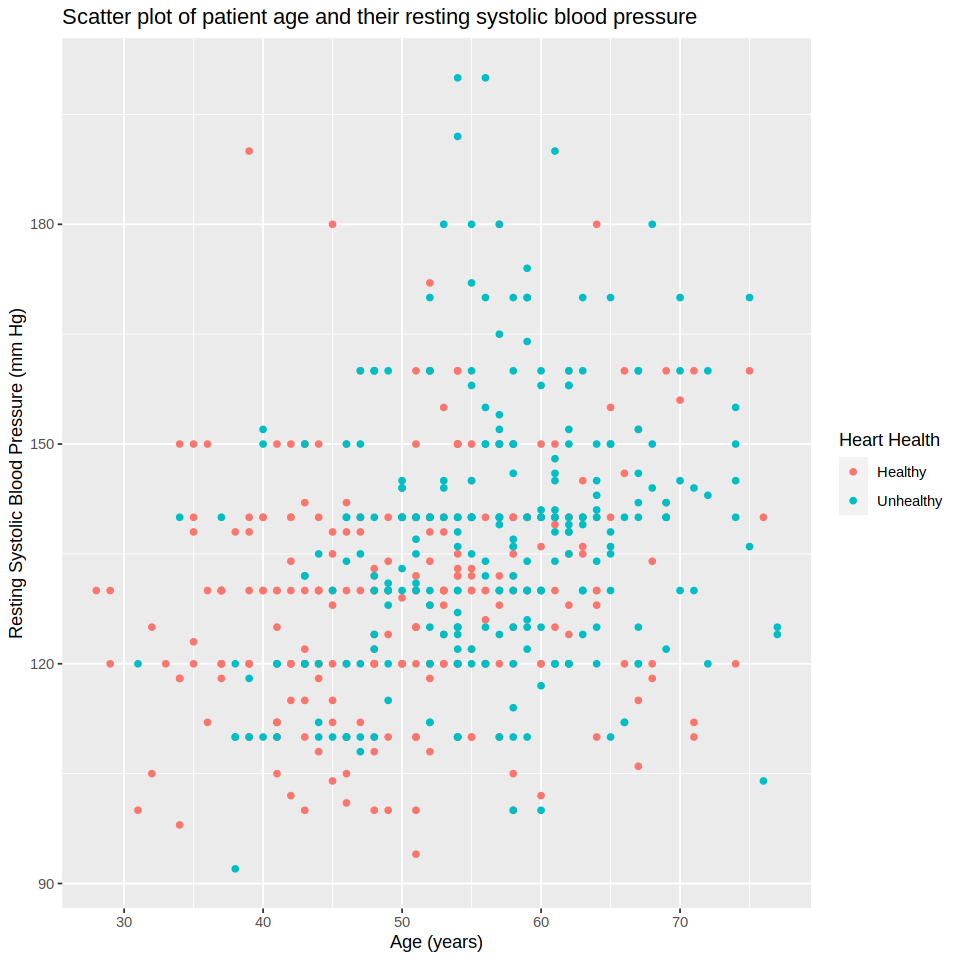

In [9]:
options(repr.plot.height = 8, repr.plot.width = 8)
plot1 <- ggplot(heart_training, aes(x = age, y = resting_bp, colour = heart_failure)) +
                geom_point() +
                labs(x = "Age (years)", y = "Resting Systolic Blood Pressure (mm Hg)", 
                     colour = "Heart Health",
                     title = "Scatter plot of patient age and their resting systolic blood pressure")

plot2 <- ggplot(heart_training, aes(x = age, y = max_heart_rate, colour = heart_failure)) +
                geom_point() +
                labs(x = "Age (years)", y = "Maximum Patient Heart Rate (BPM)", 
                     colour = "Heart Health",
                     title = "Scatter plot of patient age and their maximum heart rate")

plot3 <- ggplot(heart_training, aes(x = cholesterol, y = max_heart_rate, colour = heart_failure)) +
                geom_point() +
                labs(x = "Serum Cholesterol (mg/dL)", y = "Maximum Patient Heart Rate (BPM)",
                     colour = "Heart Health",
                     title = "Scatter plot of patient serum cholesterol levels and their maximum heart rate") +
                xlim(c(60,450))

plot2
plot3
plot1

### Methods
-
-
-

### Expected Outcomes And Significance
**Expectations:**
We expect to find that older individuals with increased resting blood pressure, increased cholesterol levels, and decreased maximum heart rate will experience heart failure in their lifetimes.

**Impact:**
An accurate prediction model could greatly help doctors diagnose heart diseases and begin early treatment to maximize an individual's health. At blood checkups, a nurse would only have to input an individual's age, resting blood pressure, cholesterol, and max heart rate in order to successfully diagnose a patient.

**Future Questions:**
- Which factors should a doctor base a successful heart disease treatment on?
- Can we create a regression model to find the healthy value of blood pressure, cholesterol, and max heart rate compared to an individual's age?
- How versatile is this model? Will it be just as accurate on individual's from a different demographic?

### Citations

fedesoriano. (September 2021). *Heart Failure Prediction Dataset*. 
    Retrieved [Dataset file] from https://www.kaggle.com/fedesoriano/heart-failure-prediction.